In [164]:
import numpy as np
import pandas as pd
import one_hot
import math


def SigmoidActivationFunction(weightedInput):
    return 1/(1 + np.exp(-weightedInput))

def SigmoidActivationFunctionDerivative(activated):
    return activated * (1 - activated) 

class Layer:
    def __init__(self,inputNodes,outputNodes) -> None:

        self.inputNodes = inputNodes
        self.outputNodes = outputNodes
        """
        WEIGHTS
        tworzy 2-wymiarową listę z wartościami wag 
        Przykładowo gdy warstwa ma 2 wejścia i 3 wyjścia
        [w11   w21   w31]
        [w12   w22   w32]
        [w13   w23   w33]
        Z wartości pierwszej kolumny obliczana jest wartość wyjściowa dla 1 wyjścia
        Z wartości drugiej kolmny obliczana jest wartość wyjściowa 2 wyjścia
        BIAS_VALUES
        tworzy 1-wymiarową listę o wymiarze ilości wyjść dla warstwy
        Do wartości wyliczonej z popagacji do przodu do wyjścia dodawana jest wartość bias
        3 wyjścia
        [bias1 bias2 bias3]
        """
        self.weights = np.random.rand(inputNodes,outputNodes) - 0.5
        self.bias_values = np.random.rand(1, outputNodes) - 0.5

    """
    Gdy mamy doczynienia z pierwszą warstwą sieci 2 cechy wejścia i 2 klasy wyścia(layer(2,2))
    funkcja przelicza cechy*wagi i zwraca wartości wyjściowych neurownów 
    Gdy wsadzimy w funkcję listę [n_próbek, n_cech] to zwraca [n_próbek, n_neuronów_wyjściowych]
    dla 5 próbek i sieci (2,2) [5,2]
    X : tablica [n_próbek, n_cech]
    -> [n_próbek, n_outputNodes]
    """
    def forward_propagation(self,X):
        self.input = X
        output_values = np.dot(X,self.weights) + self.bias_values
        self.z = output_values
        activation_values = SigmoidActivationFunction(output_values)
        self.a = activation_values
        return activation_values

    """
    X: tablica [n_próbek,n_cech]
    -> tablica [n_próbek]
    """
    def predict(self,X):
        activation_values = self.forward_propagation(X)

        predictions = np.argmax(activation_values,axis=1)

        return predictions

    def NodeCost(self,outputActivation,expectedOutput):
        error = (outputActivation - expectedOutput)**2
        return 0.5*error

class NeuralNetwork:
    def __init__(self,layerSizes,epoch,eta,minibatch_size) -> None:
        self.layers = [None]*(len(layerSizes)-1)
        for i in range(len(self.layers)):
            self.layers[i] = Layer(layerSizes[i],layerSizes[i+1])

        self.l2 = 0.
        self.epoch = epoch
        self.eta = eta
        self.errors = []
        self.minibatch_size = minibatch_size

    def network_forward_propagation(self,X):
        for layer in self.layers:
            X = layer.forward_propagation(X)

        return X

    def network_predict(self,X):
        activation_values = self.network_forward_propagation(X)

        predictions = np.argmax(activation_values,axis = 1)

        return predictions
    
    def network_loss(self,X,y, activation_values):

        outputLayer = self.layers[len(self.layers)-1]
        total_cost = 0
        cost_single_data = 0

        for xi, target in zip(activation_values,y):
            for i in range(len(activation_values[0])):
                cost_single_data += outputLayer.NodeCost(xi[i],target[i]) 

            total_cost += cost_single_data
            cost_single_data = 0

        return total_cost / len(X)

    def UpdateAllGradients(self,y, y_predict):
        delta = (y_predict - y)
        m = delta.shape[0]

        for i in range(-1, -len(self.layers) - 1, -1):
            layer = self.layers[i]
            dWeights  =  np.dot(layer.input.T, delta)
            layer.weights -= dWeights/m * self.eta
            layer.bias_values -= np.sum(delta)/m * self.eta
            delta = np.dot(delta, layer.weights.T) * SigmoidActivationFunctionDerivative(layer.input)

    def learn(self,X,y):
        y = one_hot._onehot(y,self.layers[len(self.layers)-1].outputNodes)
        for i in range(self.epoch):
            y_predicted = activation_values = self.network_forward_propagation(X)
            self.UpdateAllGradients(y, y_predicted)
            self.errors.append(self.network_loss(X,y, activation_values))
            if i % 10 == 0:
                print(f"Epoch {i} error {self.errors[-1]}")

In [61]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)

y1 =  df.iloc[0:150,4].values
y = np.where(y1[100:150] == 'Iris-virginica',2,0)
y2 = np.where(y1[50:100] == 'Iris-versicolor',1,0)
y3 = np.where(y1[0:50] == 'Iris-setosa',0,1)
y_final = np.append(y,y2)
Y = np.append(y_final,y3)
X = df.iloc[0:150,[0,2]].values
X.shape
Y.shape

(150,)

In [121]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('train.csv')

data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
X_train = X_train.T

In [122]:
one_hot._onehot(Y_train,10).shape

(41000, 10)

In [168]:
layers = [2, 4, 3]
network = NeuralNetwork(layers, 40000, 0.01, 10)
network.learn(X, Y)

Epoch 0 error 0.4462445129110511
Epoch 10 error 0.2710849696721759
Epoch 20 error 0.36586699610658924
Epoch 30 error 0.21602773495066663
Epoch 40 error 0.17609449402300142
Epoch 50 error 0.16939479549864983
Epoch 60 error 0.16585541038261545
Epoch 70 error 0.16022945005972322
Epoch 80 error 0.14825038534041238
Epoch 90 error 0.3770192683315978
Epoch 100 error 0.203889124828099
Epoch 110 error 0.17398376079505015
Epoch 120 error 0.17107363745571477
Epoch 130 error 0.1695888766380011
Epoch 140 error 0.16873882409678284
Epoch 150 error 0.1682100719304829
Epoch 160 error 0.16785980327270233
Epoch 170 error 0.16761588963039953
Epoch 180 error 0.16743875892272228
Epoch 190 error 0.16730495971317685
Epoch 200 error 0.16719900152050476
Epoch 210 error 0.1671074669899518
Epoch 220 error 0.16700912533619783
Epoch 230 error 0.16688578918374886
Epoch 240 error 0.16680440358994175
Epoch 250 error 0.1667477536200905
Epoch 260 error 0.16669376750889484
Epoch 270 error 0.1666267526102028
Epoch 280 err

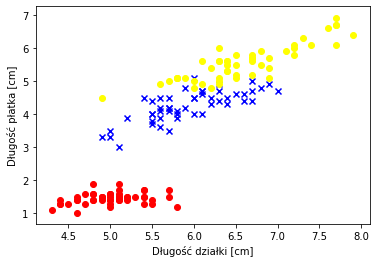

In [189]:
import matplotlib.pyplot as plt
plt.scatter(X[:50,0],X[:50,1],color = 'red', marker = 'o', label = 'Setosa')
plt.scatter(X[50:100,0],X[50:100,1],color = 'blue', marker = 'x', label = 'Versicolor')
plt.scatter(X[100:150,0],X[100:150,1],color = 'yellow', marker = 'o', label = 'Virginica')
plt.xlabel('Długość działki [cm]')
plt.ylabel('Długość płatka [cm]')
plt.show()

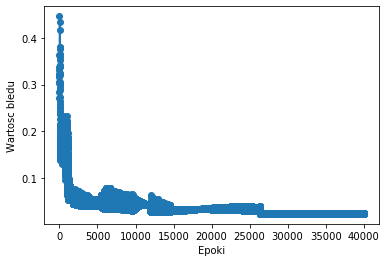

In [169]:
plt.plot(range(1,len(network.errors)+1),network.errors,marker = 'o')
plt.xlabel('Epoki')
plt.ylabel('Wartosc bledu')
plt.show()

In [135]:
network.errors[-1]

0.5579884683050389

In [159]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # konfiguruje generator znaczników i mapę kolorów
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # rysuje wykres powierzchni decyzyjnej
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.network_predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # rysuje wykres próbek
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

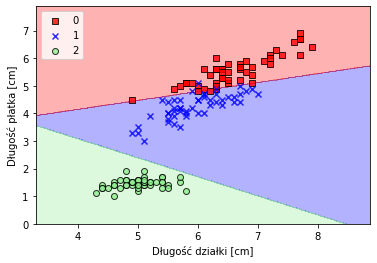

In [170]:
plot_decision_regions(X, Y, classifier=network)
plt.xlabel('Długość działki [cm]')
plt.ylabel('Długość płatka [cm]')
plt.legend(loc='upper left')
plt.show()